In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats
import statsmodels.graphics.gofplots as sgg
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KernelDensity
%matplotlib inline
#%matplotlib tk

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be r

In [2]:
my_data = pd.read_csv('/home/lin/教材/Financial_data/data/Ripple.csv')
my_data['Date']=pd.to_datetime(my_data['Date'])
my_data.dtypes

Date          datetime64[ns]
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume               float64
Market Cap           float64
dtype: object

In [3]:
my_data.set_index('Date', inplace = True)
my_data.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2018-01-08,3.36,3.36,2.07,2.46,3.315260e+09,1.303020e+11
2018-01-07,3.09,3.49,3.08,3.38,2.395150e+09,1.198190e+11
2018-01-06,3.02,3.24,2.99,3.09,2.777560e+09,1.170330e+11
2018-01-05,3.30,3.56,2.83,3.05,6.288500e+09,1.278700e+11
2018-01-04,3.12,3.84,3.12,3.20,8.103660e+09,1.207630e+11


In [4]:
my_data.describe()

,Open,High,Low,Close,Volume,Market Cap
count,1619.000000,1619.000000,1619.000000,1619.000000,1.474000e+03,1.619000e+03
mean,0.065686,0.071800,0.061426,0.067220,9.482681e+07,2.423942e+09
std,0.246393,0.279678,0.225367,0.253546,5.595052e+08,9.562257e+09
min,0.002809,0.003082,0.002802,0.002810,8.316000e+03,2.196030e+07
25%,0.006046,0.006161,0.005956,0.006050,2.930168e+05,1.456445e+08
50%,0.007878,0.008014,0.007707,0.007879,7.020645e+05,2.362570e+08
75%,0.016074,0.016893,0.015446,0.016123,2.812955e+06,3.484395e+08
max,3.360000,3.840000,3.120000,3.380000,8.108390e+09,1.303020e+11


In [5]:
close = np.flip(my_data['Close'], 0)
close.head()

Date
2013-08-04    0.005882
2013-08-05    0.005613
2013-08-06    0.004680
2013-08-07    0.004417
2013-08-08    0.004254
Name: Close, dtype: float64

In [6]:
volume = my_data['Volume'].dropna()
volume.head()

Date
2018-01-08    3.315260e+09
2018-01-07    2.395150e+09
2018-01-06    2.777560e+09
2018-01-05    6.288500e+09
2018-01-04    8.103660e+09
Name: Volume, dtype: float64

plot raw data


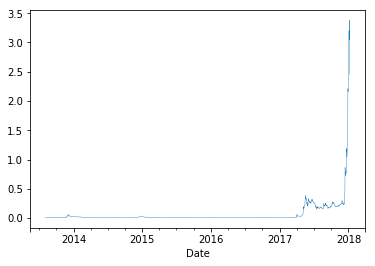

In [7]:
print('plot raw data')
#%matplotlib tk
close.plot(linewidth = 0.4)

In [8]:
logR = np.log(close).diff()
logR.head()

Date
2013-08-04         NaN
2013-08-05   -0.046812
2013-08-06   -0.181787
2013-08-07   -0.057837
2013-08-08   -0.037601
Name: Close, dtype: float64

In [9]:
logR.values

array([        nan, -0.0468115 , -0.18178723, ...,  0.0130295 ,
        0.08970462, -0.31771436])

In [10]:
logR.drop(logR.index[0], inplace = True)

plot log return


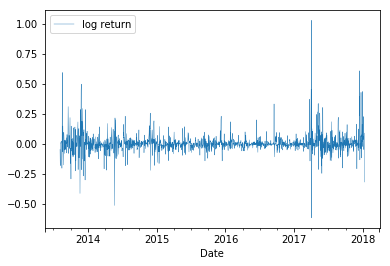

In [11]:
print('plot log return')

#%matplotlib tk
logR.plot(linewidth = 0.4)
plt.legend(['log return'])
plt.show()

In [12]:
logR.describe()

count    1618.000000
mean        0.003731
std         0.079982
min        -0.616273
25%        -0.021178
50%        -0.002303
75%         0.021177
max         1.027356
Name: Close, dtype: float64

In [13]:
stats.skew(logR)

2.1810699878397064

In [14]:
stats.kurtosis(logR)

28.450608026769

In [15]:
adfuller(logR) #test for stationary

(-10.924169213029211,
 1.0201212291578786e-19,
 11,
 1606,
 {'1%': -3.4344283205802606,
  '10%': -2.5677289969277726,
  '5%': -2.8633413399051144},
 -3606.664273929593)

In [16]:
stats.anderson(logR) #test for normal distribution

AndersonResult(statistic=102.33883952356314, critical_values=array([0.575, 0.654, 0.785, 0.916, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

plot bin number score


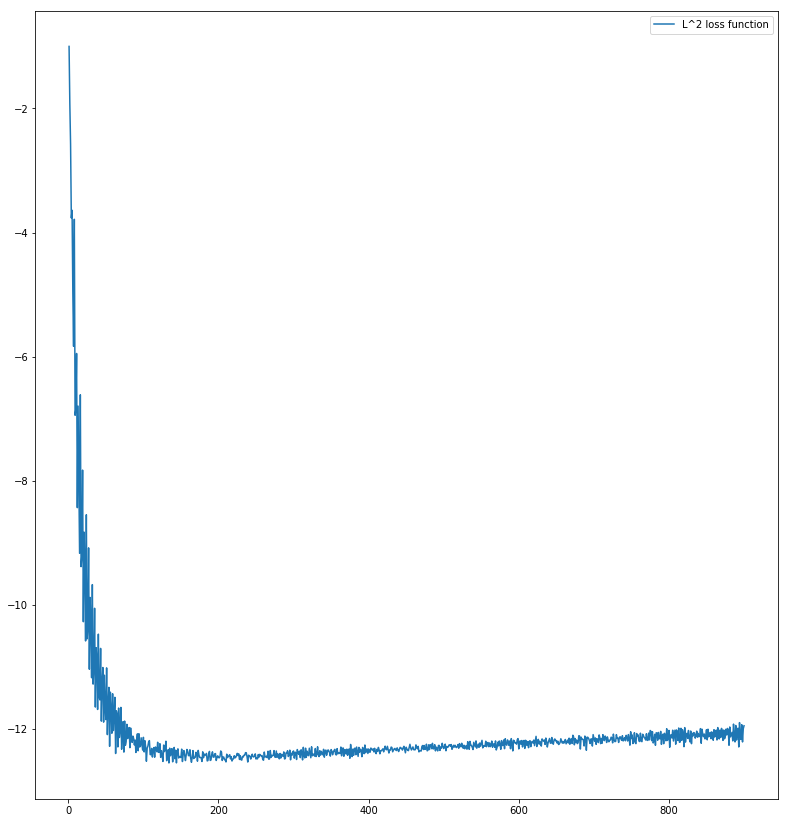

In [17]:
print('plot bin number score')
%matplotlib tk
numSmoothingFactor = 900
#this guy should be a input to the optimized bin number function, it should also take nomalized data
scores = np.zeros(numSmoothingFactor)
binNums = range(1,numSmoothingFactor + 1)
for binNum in binNums:
    frequen, binEdges = np.histogram(logR, bins = binNum)
    numObser = logR.count().astype(float)
    proEst = frequen / numObser
    sumFreqSqua = np.sum(proEst ** 2)
    score = ((2. * binNum) / ( numObser - 1.)) - (sumFreqSqua * (numObser + 1.) * binNum/ (numObser - 1.))
    scores[binNum - 1] = score

plt.plot(binNums, scores)
plt.legend(['L^2 loss function'])

histgram and Gaussian


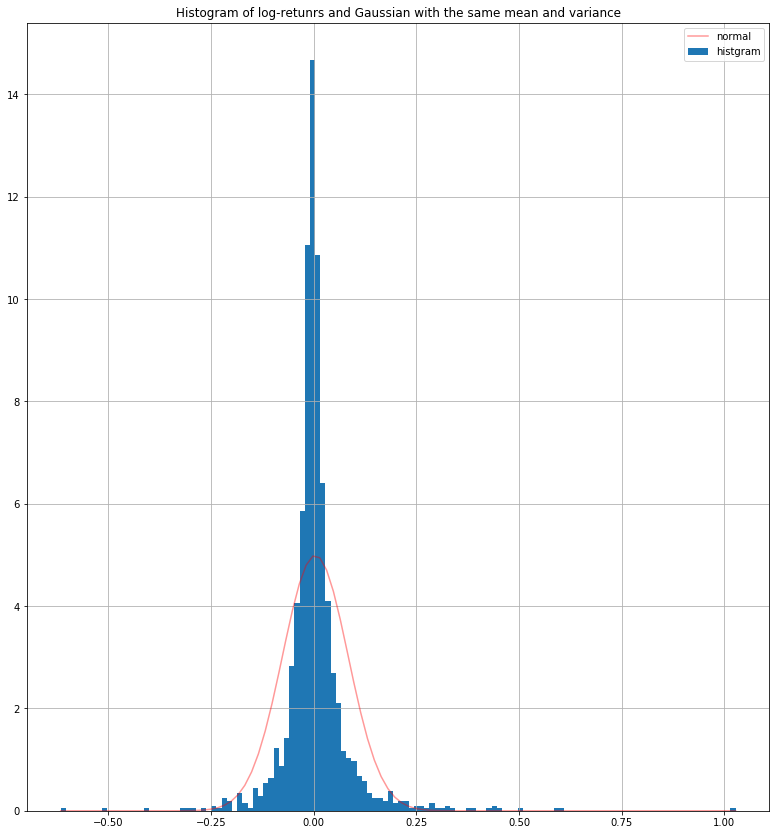

In [18]:
print('histgram and Gaussian')
numbins = int(130) 
logR.hist(bins = numbins, normed=True)


mu_log = np.mean(logR)
sigma_log = np.std(logR)
x_ticks = np.linspace(min(logR), max(logR),100)
plt.plot(x_ticks, 1./((2.*np.pi)**0.5 *sigma_log)*np.exp(-((x_ticks - mu_log)/sigma_log)**2/2), 'r', alpha = 0.4)
plt.title('Histogram of log-retunrs and Gaussian with the same mean and variance')
plt.legend(['normal', 'histgram'])

autocorrelations


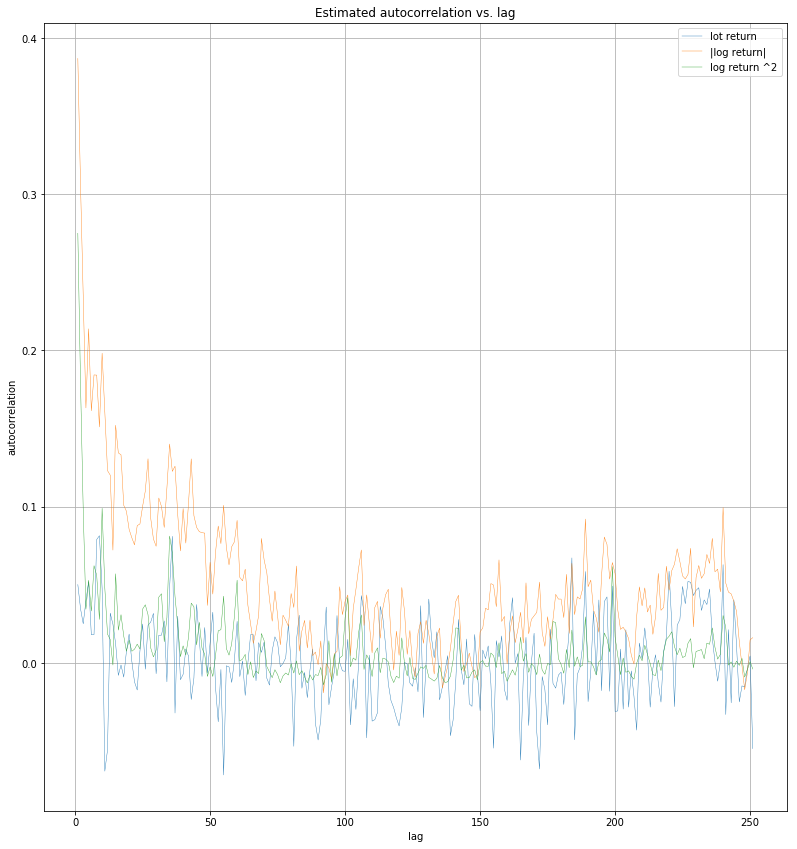

In [19]:
print('autocorrelations')
autocorr_logR = [logR.autocorr(lag=_) for _ in range(1,252)]
autocorr_abs_logR = [abs(logR).autocorr(lag=_) for _ in range(1,252)]
autocorr_sqLogR = [(logR ** 2).autocorr(lag=_) for _ in range(1,252)]
plt.plot(range(1, 252),autocorr_logR, range(1, 252), autocorr_abs_logR, range(1, 252), autocorr_sqLogR, linewidth = 0.4)
plt.title('Estimated autocorrelation vs. lag')
plt.legend(['lot return', '|log return|', 'log return ^2'], loc = 1)
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.grid(True)

In [20]:
posiR = logR[logR > 0].dropna()
negaR = logR[logR <= 0].dropna()

In [21]:
np.unique(posiR > 0)

array([ True])

In [22]:
np.unique(negaR <= 0)

array([ True])

In [23]:
sortedPosiR = posiR.sort_values()
sortedNegaR = (-negaR).sort_values()
mirrorNegative = sortedNegaR.append(-sortedNegaR)
numObs = logR.count()

In [24]:
mirrorPosi = sortedPosiR.append(-sortedPosiR)

loglog data and Gaussion


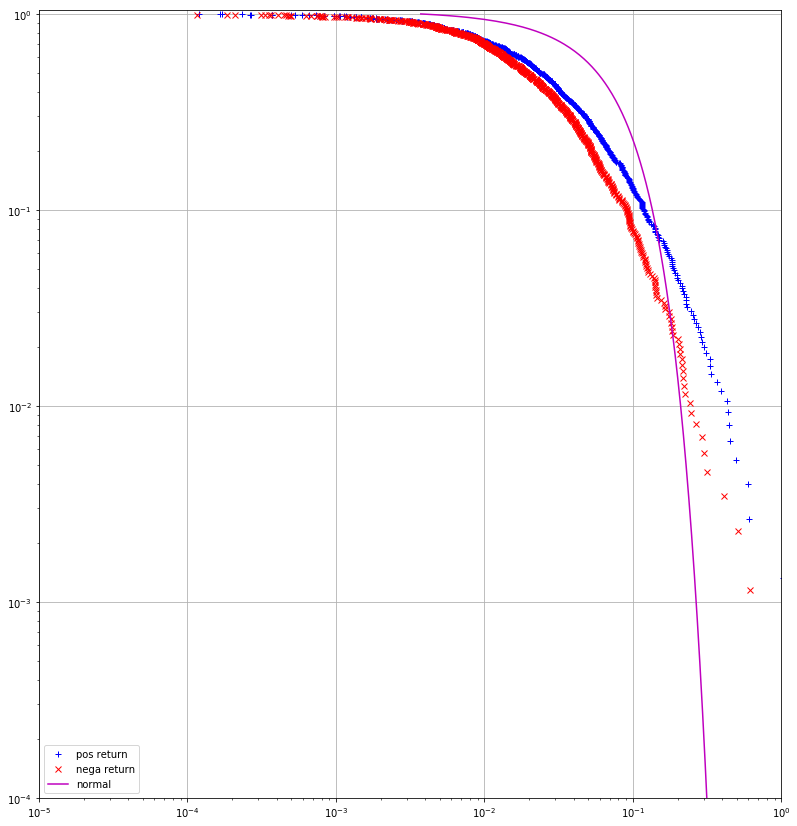

In [25]:
print('loglog data and Gaussion')
plt.loglog(sortedPosiR, 1 - (range(1, sortedPosiR.count() + 1))/(sortedPosiR.count() + 1), '+b')
plt.loglog(sortedNegaR, 1 - (range(1, sortedNegaR.count() + 1))/(sortedNegaR.count() + 1), 'xr')
domain = np.linspace(mu_log, max(abs(logR)), 1000)
plt.loglog(domain, 1 - (stats.norm.cdf(domain, mu_log, sigma_log) - 0.5) * 2, 'm')
plt.ylim([1e-4, 1.05])
plt.xlim([1e-5, 1])
plt.legend(['pos return', 'nega return', 'normal'], loc = 3)
plt.grid(True)

volatility of log return


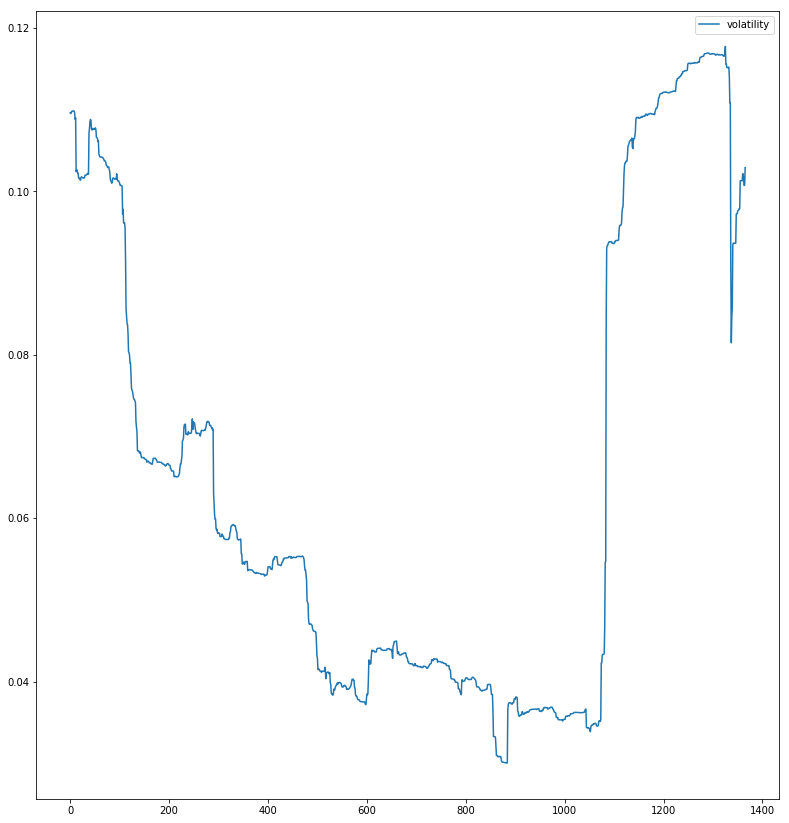

In [26]:
print('volatility of log return')
window = 252
cumlogR = logR.cumsum()
cumlogRSq = (logR ** 2).cumsum()
sqRunAvg = (cumlogRSq[cumlogRSq.index[window :]].values - cumlogRSq[cumlogRSq.index[: cumlogRSq.count() - window]].values)/window
RuningAvg = (cumlogR[cumlogR.index[window :]].values - cumlogR[cumlogR.index[: cumlogR.count() - window]].values)/window
volatility = np.sqrt(sqRunAvg - RuningAvg ** 2)
plt.figure()
plt.plot(volatility)
plt.legend(['volatility'])

volatility of volume


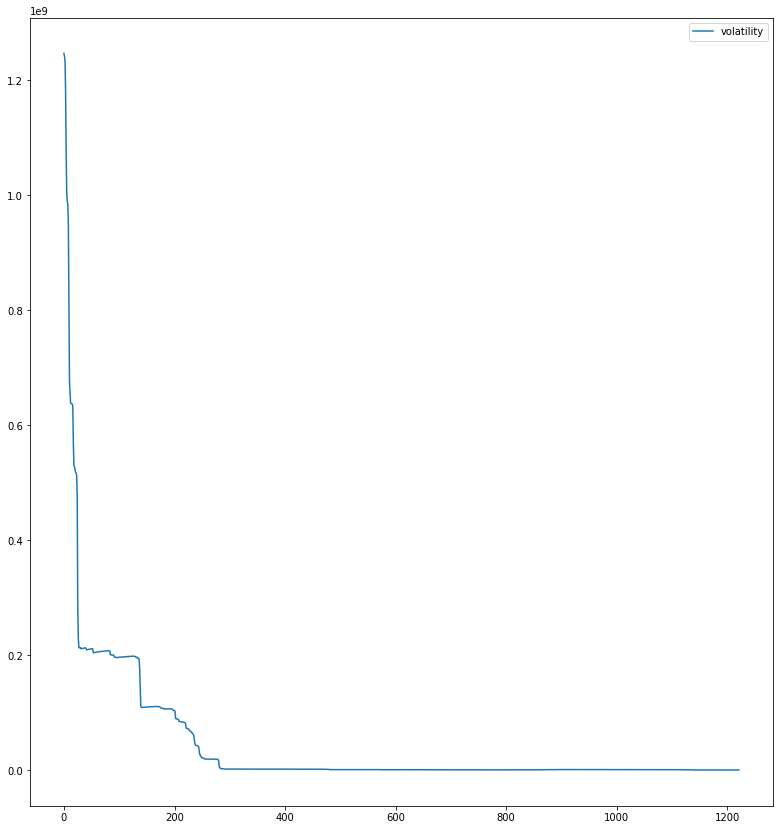

In [27]:
print('volatility of volume')
window = 252
cumvolume = volume.cumsum()
cumvolumeSq = (volume ** 2).cumsum()
sqRunAvg = (cumvolumeSq[cumvolumeSq.index[window :]].values - cumvolumeSq[cumvolumeSq.index[: cumvolumeSq.count() - window]].values)/window
RuningAvg = (cumvolume[cumvolume.index[window :]].values - cumvolume[cumvolume.index[: cumvolume.count() - window]].values)/window
volatility = np.sqrt(sqRunAvg - RuningAvg ** 2)
plt.figure()
plt.plot(volatility)
plt.legend(['volatility'])

qq fit whole set with Gaussian


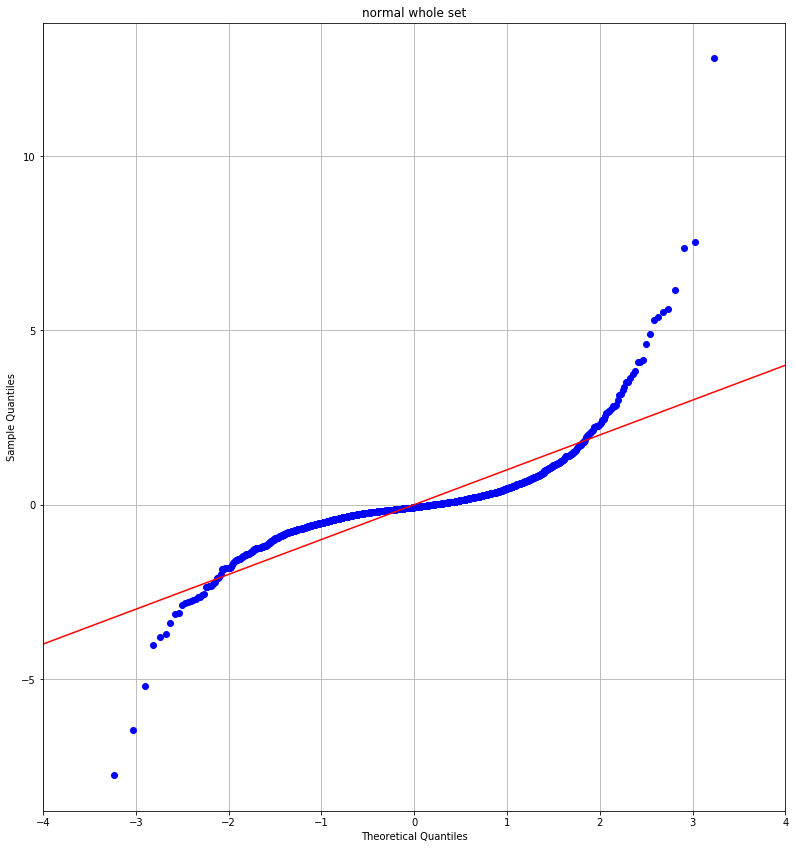

In [28]:
print('qq fit whole set with Gaussian')
normal_para = [mu_log, sigma_log]
sgg.qqplot(logR, stats.norm, fit = True, line = '45')
plt.title('normal whole set')
plt.xlim([-4, 4])
plt.grid(True)

qq fit whole set with t


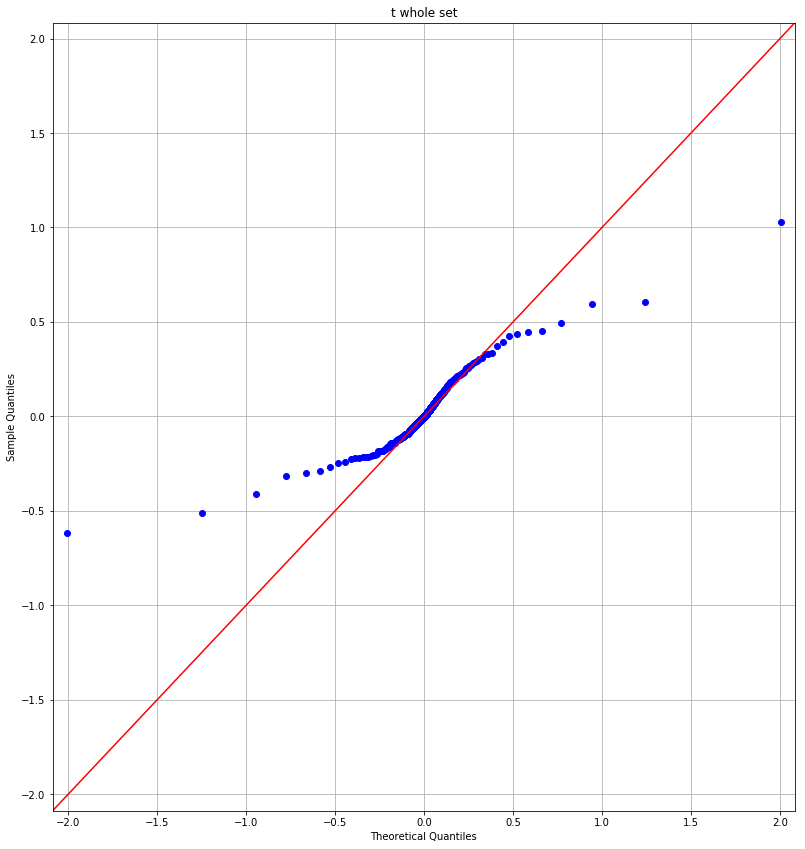

In [29]:
print('qq fit whole set with t')
t_para = stats.t.fit(logR, loc = mu_log, scale = sigma_log)
loc, scale = t_para[1:]
fake_distargs = (t_para[0],)
sgg.qqplot(logR, stats.t, fit = False, line = '45',distargs = fake_distargs, loc=loc, scale=scale)
plt.title('t whole set')
plt.grid(True)

qq fit mirrored positive with t


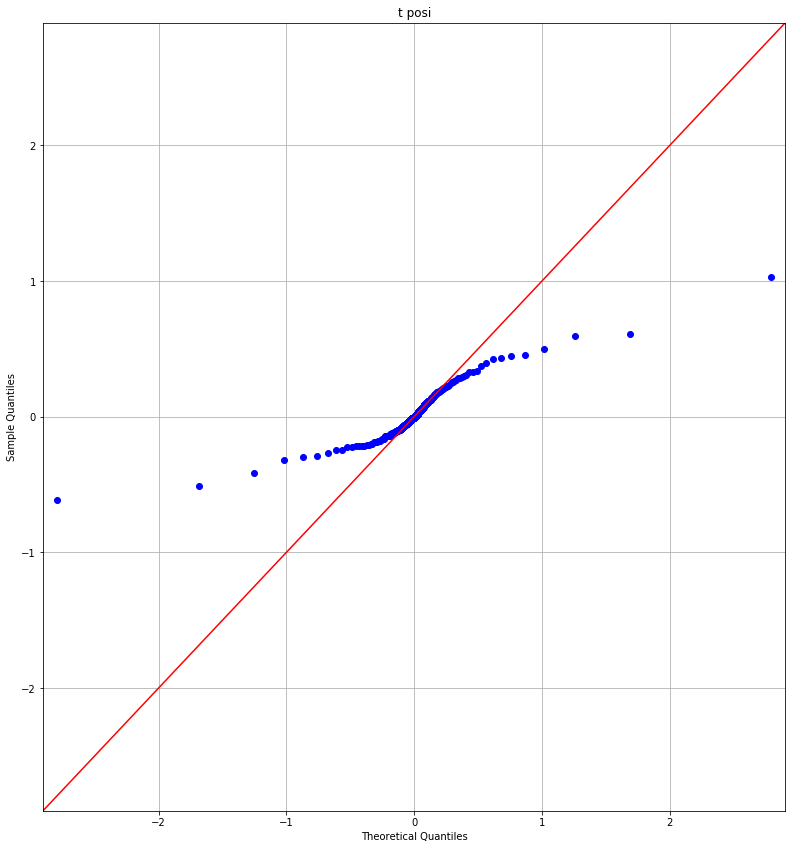

In [30]:
print('qq fit mirrored positive with t')
posi_t_para = stats.t.fit(mirrorPosi)
loc, scale = posi_t_para[1:]
fake_distargs = (posi_t_para[0],)
sgg.qqplot(logR, stats.t, fit = False, line = '45',distargs = fake_distargs, loc=loc, scale=scale)
plt.title ('t posi')
plt.grid(True)

qq fit mirrored negative with t


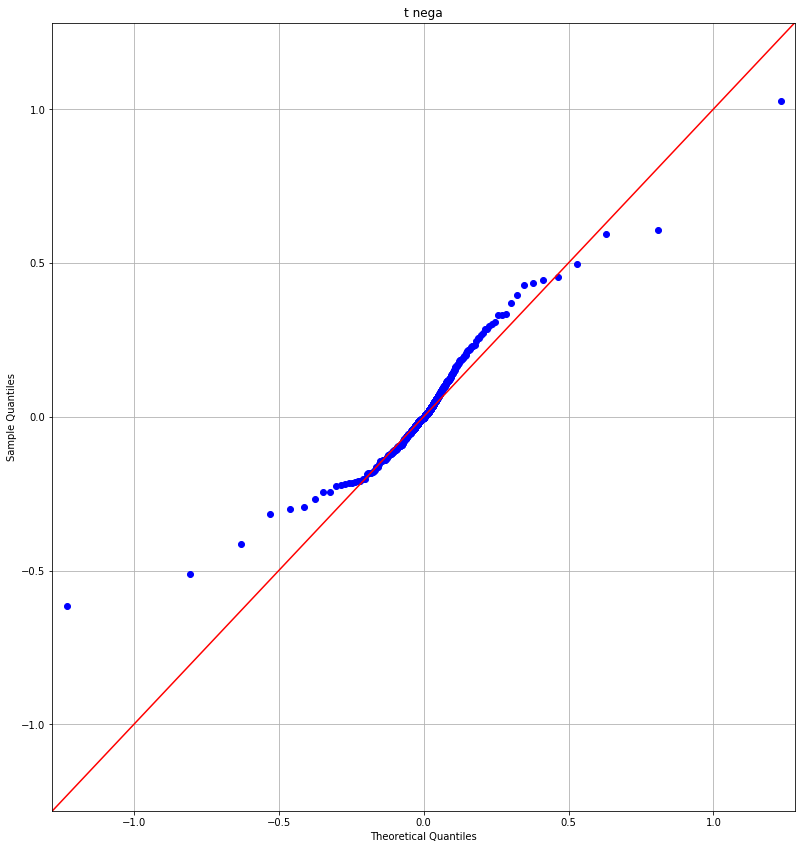

In [31]:
print('qq fit mirrored negative with t')
nega_t_para = stats.t.fit(mirrorNegative)
loc, scale = nega_t_para[1:]
fake_distargs = (nega_t_para[0],)
sgg.qqplot(logR, stats.t, fit = False, line = '45',distargs = fake_distargs, loc=loc, scale=scale)
plt.title('t nega')
plt.grid(True)

qq fit whole set with gen extreme


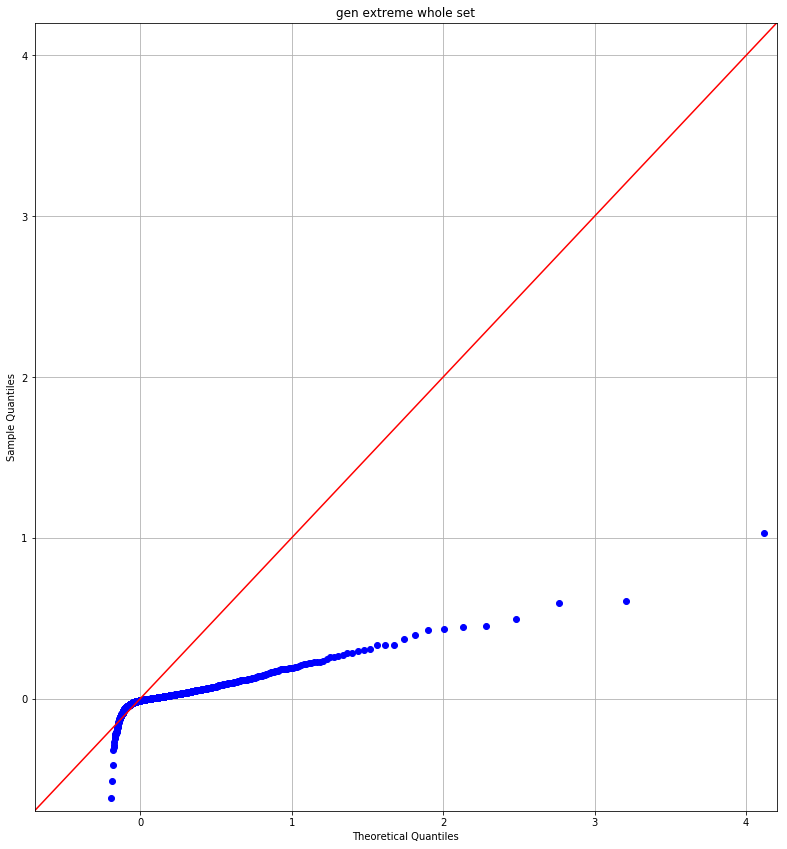

In [32]:
print('qq fit whole set with gen extreme')
gen_para = stats.genextreme.fit(logR, loc = mu_log, scale = sigma_log)
#gen_para = list(gen_para)
#gen_para[0] = gen_para[0] * (-1)

# it's this one

loc, scale = gen_para[1:]
fake_distargs = (gen_para[0],)

pp = sgg.ProbPlot(logR, dist=stats.genextreme, distargs=fake_distargs, fit=False, loc=loc, scale=scale)
fig = pp.qqplot(line='45')
plt.title('gen extreme whole set')
plt.grid(True)

qq fit negative half with gen pareto


/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2062: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2306: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


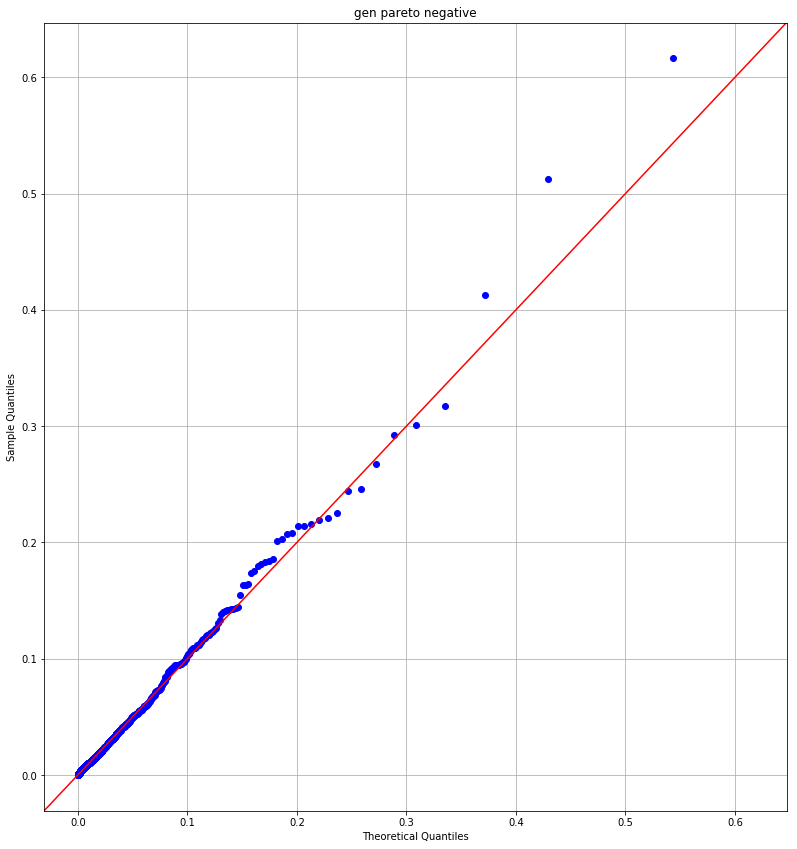

In [52]:
print('qq fit negative half with gen pareto')
nega_gen_para = stats.genpareto.fit(sortedNegaR, loc = mu_log, scale = sigma_log)

#gen_para = list(gen_para)
#gen_para[0] = gen_para[0] * (-1)

# it's this one

loc, scale = nega_gen_para[1:]
fake_distargs = (nega_gen_para[0],)

pp = sgg.ProbPlot(sortedNegaR, dist=stats.genpareto, distargs=fake_distargs, fit=False, loc=loc, scale=scale)
fig = pp.qqplot(line='45')
plt.title('gen pareto negative')
plt.grid(True)

In [34]:
nega_gen_para

(0.28568260574688875, -5.170894848096893e-11, 0.026269242669344807)

qq fit positive half with gen pareto


/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2062: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2306: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


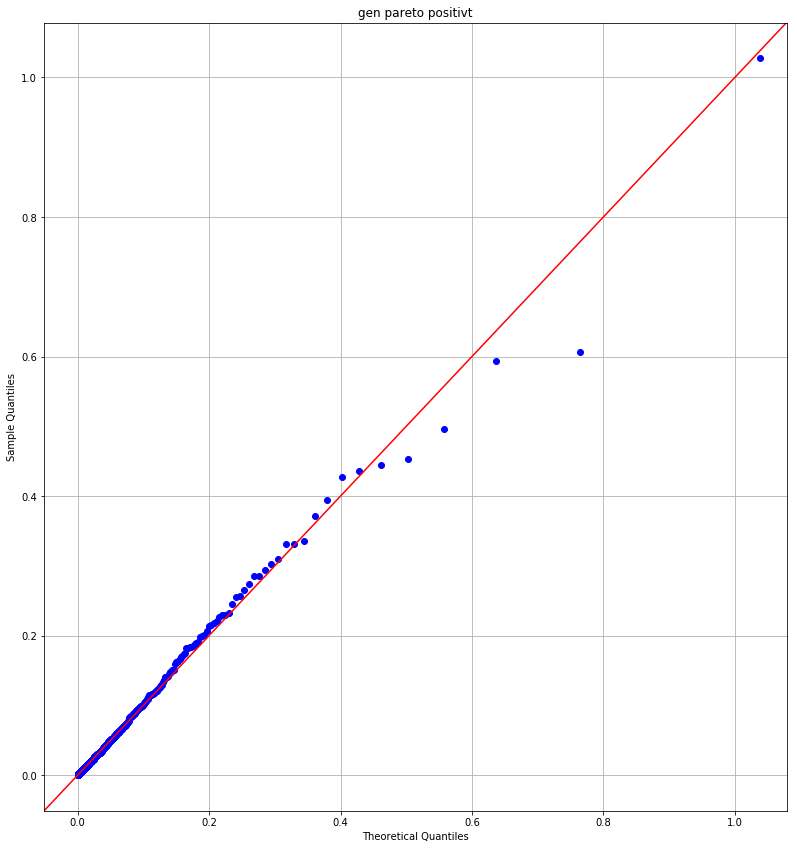

In [51]:
print('qq fit positive half with gen pareto')
posi_gen_para = stats.genpareto.fit(sortedPosiR, loc = mu_log, scale = sigma_log)

#gen_para = list(gen_para)
#gen_para[0] = gen_para[0] * (-1)

# it's this one

loc, scale = posi_gen_para[1:]
fake_distargs = (posi_gen_para[0],)

pp = sgg.ProbPlot(sortedPosiR, dist=stats.genpareto, distargs=fake_distargs, fit=False, loc=loc, scale=scale)
fig = pp.qqplot(line='45')
plt.title('gen pareto positivt')
plt.grid(True)

In [36]:
posi_gen_para

(0.40798454909670245, 0.00011950982293544837, 0.030437897578615473)

negative return, hist, fitted gen pareto and mirrored negative t


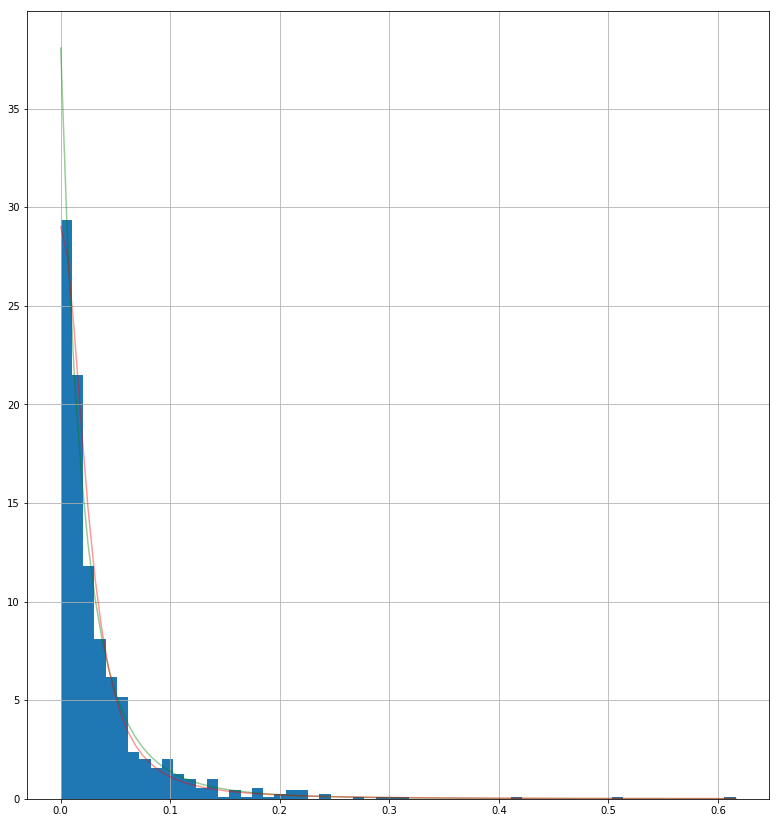

In [37]:
print('negative return, hist, fitted gen pareto and mirrored negative t')
numbins = int(60) 
sortedNegaR.hist(bins = numbins, normed=True)
x_ticks = np.linspace(min(sortedNegaR), max(sortedNegaR),100)
plt.plot(x_ticks, stats.genpareto.pdf(x_ticks, c =nega_gen_para[0] , loc = nega_gen_para[1], scale = nega_gen_para[2]),'g', alpha = 0.4)
plt.plot(x_ticks, stats.t.pdf(x_ticks, df =nega_t_para[0] , loc = nega_t_para[1], scale = nega_t_para[2]) * 2, 'r', alpha = 0.4)

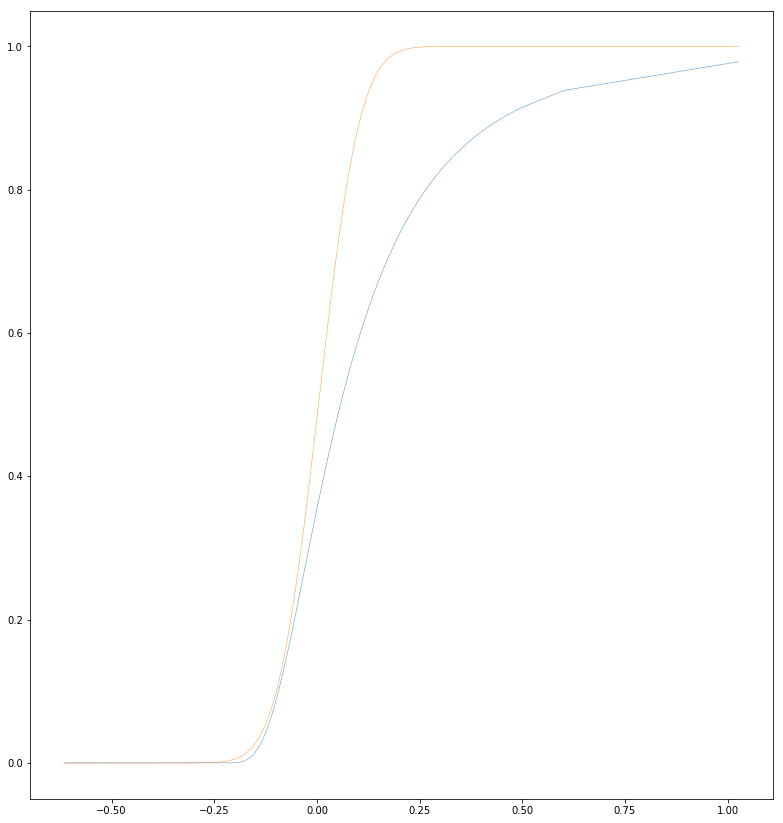

In [38]:
plt.plot(logR.sort_values(), stats.genextreme.cdf(logR.sort_values(), c =gen_para[0] , loc = gen_para[1], scale = gen_para[2]), linewidth = 0.4)
plt.plot(logR.sort_values(), stats.norm.cdf(logR.sort_values(), mu_log, sigma_log), linewidth = 0.4)

In [60]:
t_para

(1.455265745293747, -0.0022507700885327038, 0.02479560679814534)

loglog data halves with whole gen extreme, t, normal


(0.0001, 1.2)

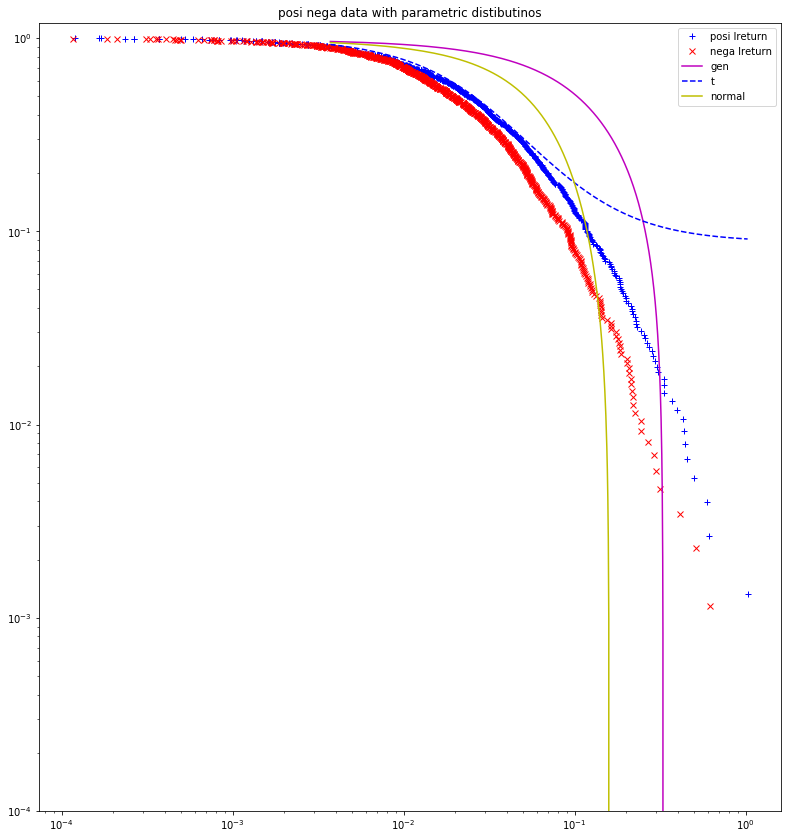

In [63]:
print('loglog data halves with whole gen extreme, t, normal')
#%matplotlib tk
domain = np.linspace(mu_log, max(abs(logR)), 1000)
plt.figure()
plt.loglog(sortedPosiR, 1 - (range(1, sortedPosiR.count() + 1))/(sortedPosiR.count() + 1), '+b')
plt.loglog(sortedNegaR, 1 - (range(1, sortedNegaR.count() + 1))/(sortedNegaR.count() + 1), 'xr')
plt.loglog(domain, 1 - (stats.genextreme.cdf(domain, c =gen_para[0] , loc = gen_para[1], scale = gen_para[2]) - 0.357 + 0.012 ) * 2, 'm')
plt.loglog(domain, 1 - (stats.t.cdf(domain, df = t_para[0] , loc = t_para[1], scale = t_para[2]) - 0.544  ) * 2, '--b')
plt.loglog(domain, 1 - (stats.norm.cdf(domain, mu_log, sigma_log) - 0.486 + 0.012 ) * 2, 'y')
plt.title('posi nega data with parametric distibutinos')
plt.legend(['posi lreturn', 'nega lreturn', 'gen', 't','normal'])
plt.ylim([1e-4, 1.2])

pdf of three whole set fitted distribution


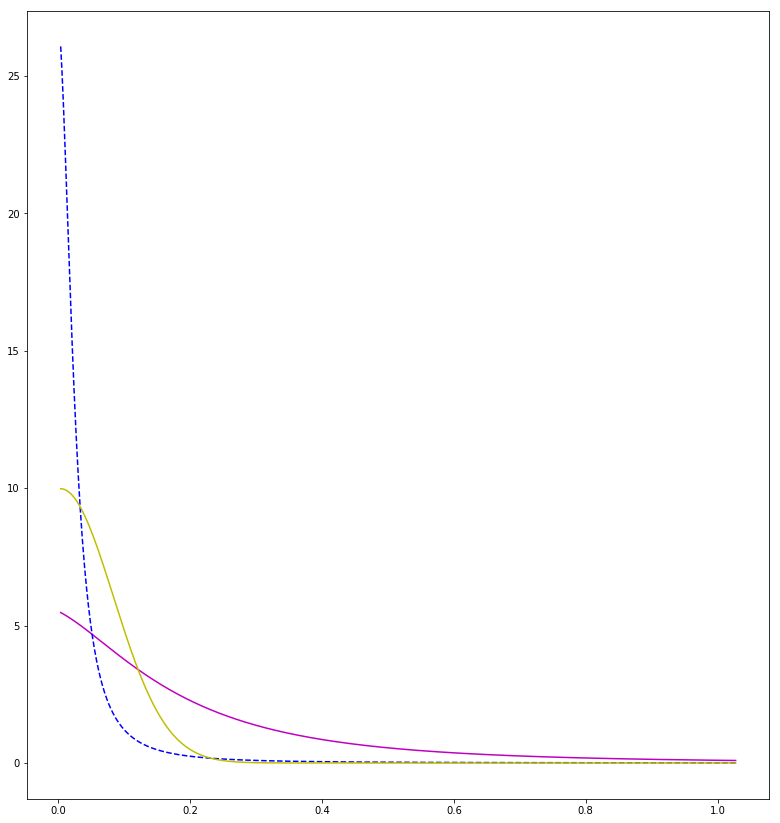

In [40]:
print('pdf of three whole set fitted distribution')
plt.figure()
plt.plot(domain, (stats.genextreme.pdf(domain, c =gen_para[0] , loc = gen_para[1], scale = gen_para[2])) * 2, 'm')
plt.plot(domain, (stats.t.pdf(domain, df = t_para[0] , loc = t_para[1], scale = t_para[2])) * 2, '--b')
plt.plot(domain, (stats.norm.pdf(domain, mu_log, sigma_log)) * 2, 'y')

histgram of whole set plotted with whole set fitted gen extreme, t, normal


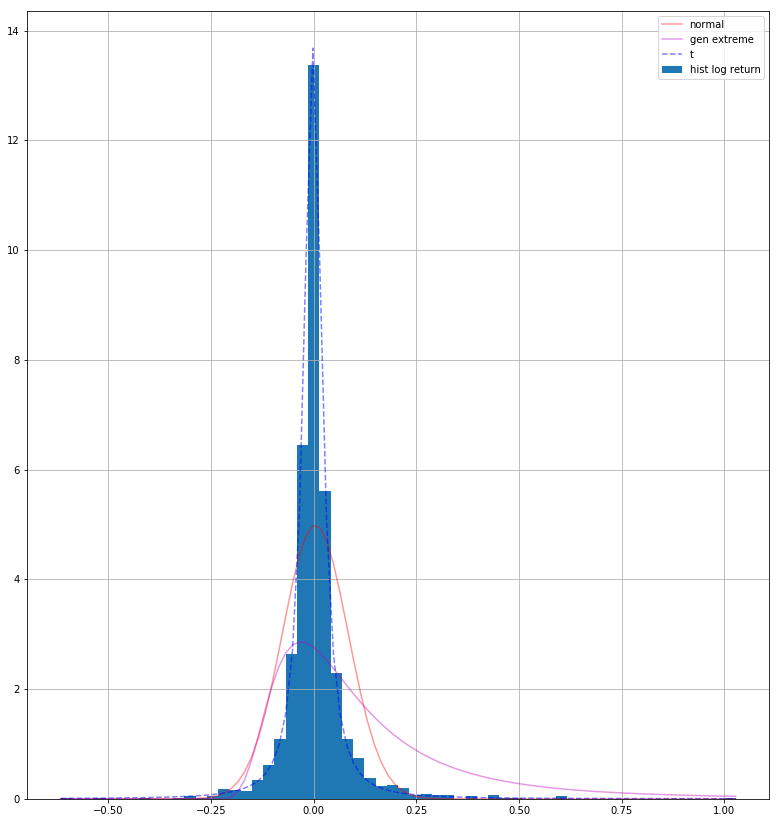

In [41]:
print('histgram of whole set plotted with whole set fitted gen extreme, t, normal')
#%matplotlib inline
#%matplotlib qt
numbins = int(60) 
logR.hist(bins = numbins, normed=True)


mu_log = np.mean(logR)
sigma_log = np.std(logR)
x_ticks = np.linspace(min(logR), max(logR),100)
plt.plot(x_ticks, 1./((2.*np.pi)**0.5 *sigma_log)*np.exp(-((x_ticks - mu_log)/sigma_log)**2/2), 'r', alpha = 0.4)
plt.plot(x_ticks, (stats.genextreme.pdf(x_ticks, c =gen_para[0] , loc = gen_para[1], scale = gen_para[2])), 'm', alpha = 0.4)
plt.plot(x_ticks, (stats.t.pdf(x_ticks, df = t_para[0] , loc = t_para[1], scale = t_para[2])), '--b', alpha = 0.5)
#plt.plot(logR_grid, pdf, '--r')
plt.legend(['normal', 'gen extreme', 't', 'hist log return'])

loglog halves with whole_gen_extreme and gen_pareto and normal


(0.0004, 1.05)

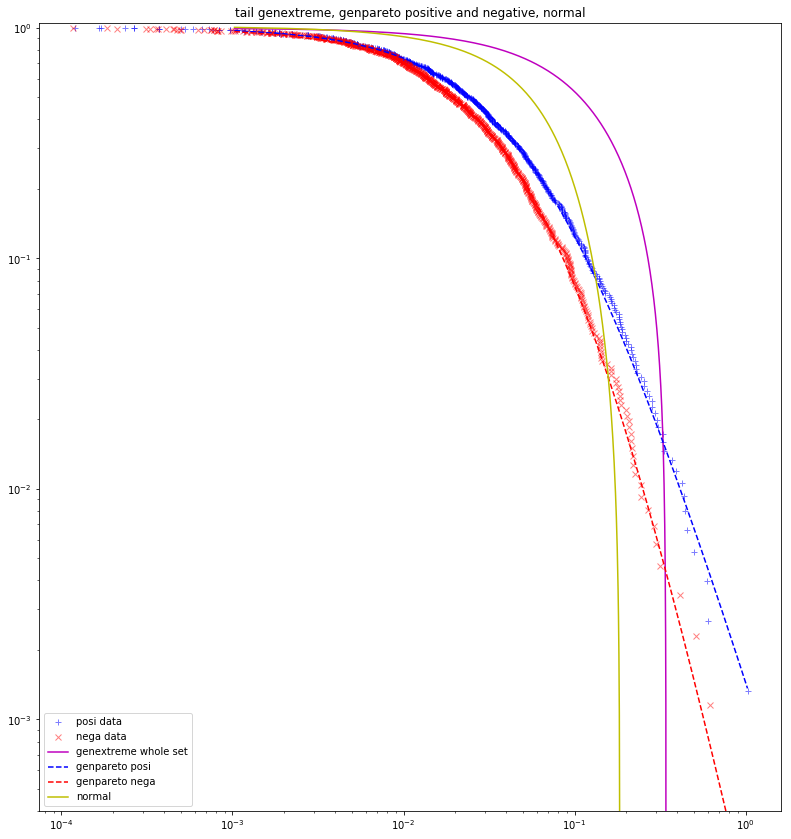

In [71]:
print('loglog halves with whole_gen_extreme and gen_pareto and normal')
plt.figure()
domain = np.linspace(max(abs(logR))/1000, max(abs(logR)), 1000)
plt.loglog(sortedPosiR, 1 - (range(1, sortedPosiR.count() + 1))/(sortedPosiR.count() + 1), '+b', alpha = 0.5)
plt.loglog(sortedNegaR, 1 - (range(1, sortedNegaR.count() + 1))/(sortedNegaR.count() + 1), 'xr', alpha = 0.5)
plt.loglog(domain, 1 - (stats.genextreme.cdf(domain, c =gen_para[0] , loc = gen_para[1], scale = gen_para[2]) - 0.365 + 0.012) * 2, 'm')
plt.loglog(domain, 1 - (stats.genpareto.cdf(domain, c =posi_gen_para[0] , loc = posi_gen_para[1], scale = posi_gen_para[2])), '--b')
plt.loglog(domain, 1 - (stats.genpareto.cdf(domain, c =nega_gen_para[0] , loc = nega_gen_para[1], scale = nega_gen_para[2])), '--r')
plt.loglog(domain, 1 - (stats.norm.cdf(domain, mu_log, sigma_log) - 0.5 + 0.012) * 2, 'y')
plt.title('tail genextreme, genpareto positive and negative, normal')
plt.legend(['posi data', 'nega data', 'genextreme whole set', 'genpareto posi', 'genpareto nega', 'normal'], loc = 3)
plt.ylim([4e-4, 1.05])

loglog halves with whole_t and mirror_fitted_t and normal


(0.0001, 1.05)

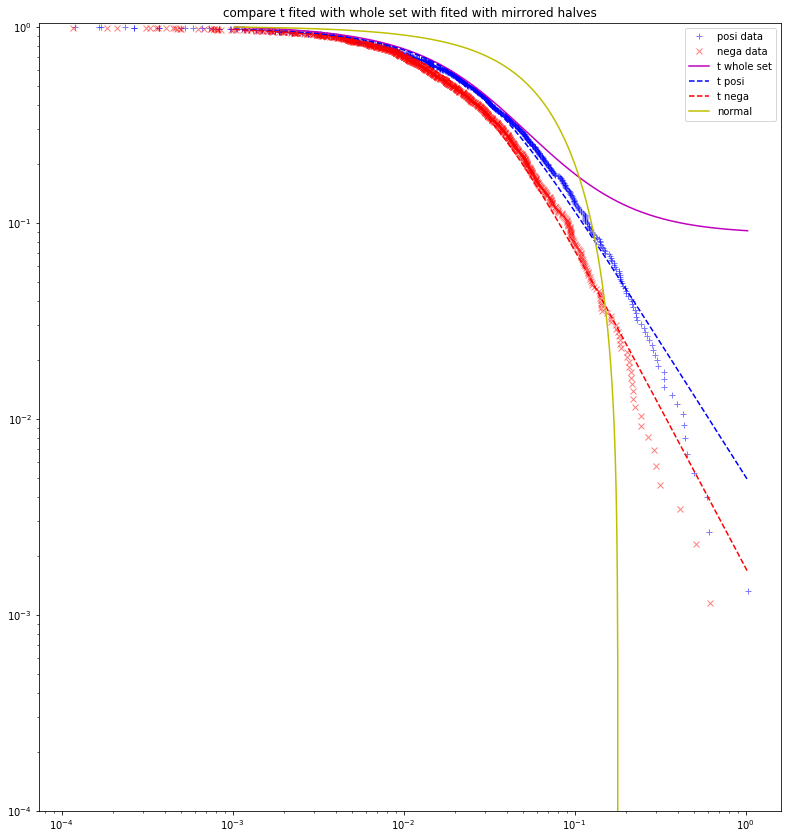

In [74]:
print('loglog halves with whole_t and mirror_fitted_t and normal')

#%matplotlib tk
plt.figure()
domain = np.linspace(max(abs(logR))/1000, max(abs(logR)), 1000)
plt.loglog(sortedPosiR, 1 - (range(1, sortedPosiR.count() + 1))/(sortedPosiR.count() + 1), '+b', alpha = 0.5)
plt.loglog(sortedNegaR, 1 - (range(1, sortedNegaR.count() + 1))/(sortedNegaR.count() + 1), 'xr', alpha = 0.5)
plt.loglog(domain, 1 - (stats.t.cdf(domain, df =t_para[0] , loc = t_para[1], scale = t_para[2]) - 0.544) * 2, 'm')
plt.loglog(domain, 1 - (stats.t.cdf(domain, df =posi_t_para[0] , loc = posi_t_para[1], scale = posi_t_para[2]) - 0.5) * 2, '--b')
plt.loglog(domain, 1 - (stats.t.cdf(domain, df =nega_t_para[0] , loc = nega_t_para[1], scale = nega_t_para[2]) - 0.5) * 2, '--r')

plt.loglog(domain, 1 - (stats.norm.cdf(domain, mu_log, sigma_log) - 0.486) * 2, 'y')
plt.title('compare t fited with whole set with fited with mirrored halves')
plt.legend(['posi data', 'nega data', 't whole set', 't posi', 't nega', 'normal'])
plt.ylim([1e-4, 1.05])

histgram of whole set plotted with whole set fitted t and mirror_fitted_t


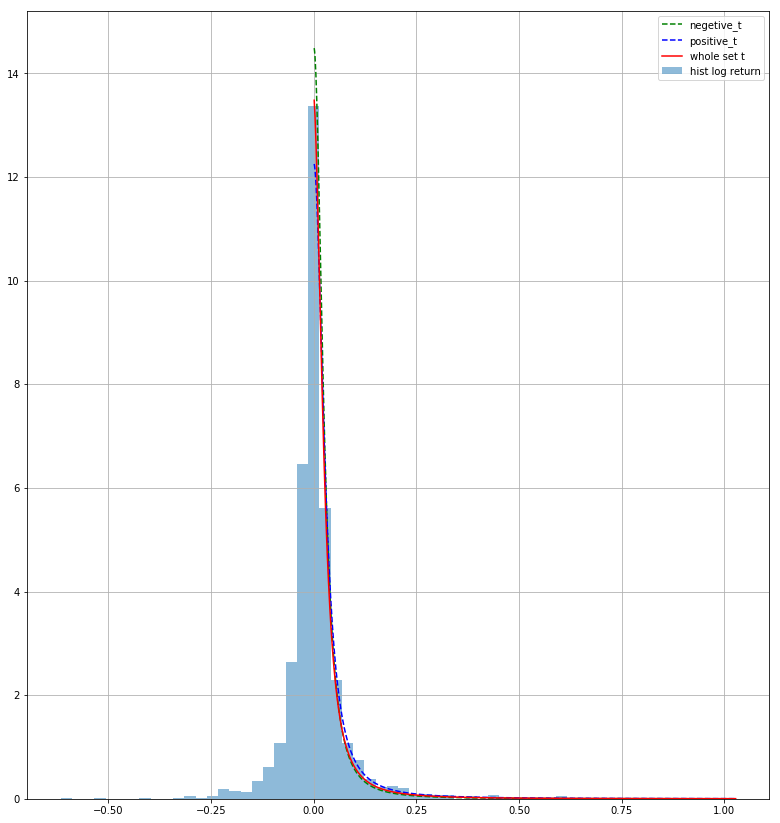

In [44]:
print('histgram of whole set plotted with whole set fitted t and mirror_fitted_t')

numbins = int(60) 
logR.hist(bins = numbins, normed=True, alpha = 0.5)
plt.plot(domain, (stats.t.pdf(domain, df = nega_t_para[0] , loc = nega_t_para[1], scale = nega_t_para[2])), '--g')
plt.plot(domain, (stats.t.pdf(domain, df = posi_t_para[0] , loc = posi_t_para[1], scale = posi_t_para[2])), '--b')
plt.plot(domain, (stats.t.pdf(domain, df = t_para[0] , loc = t_para[1], scale = t_para[2])), 'r', )

plt.legend(['negetive_t', 'positive_t', 'whole set t', 'hist log return'])

histgram of whole set plotted with halves fitted gen pareto


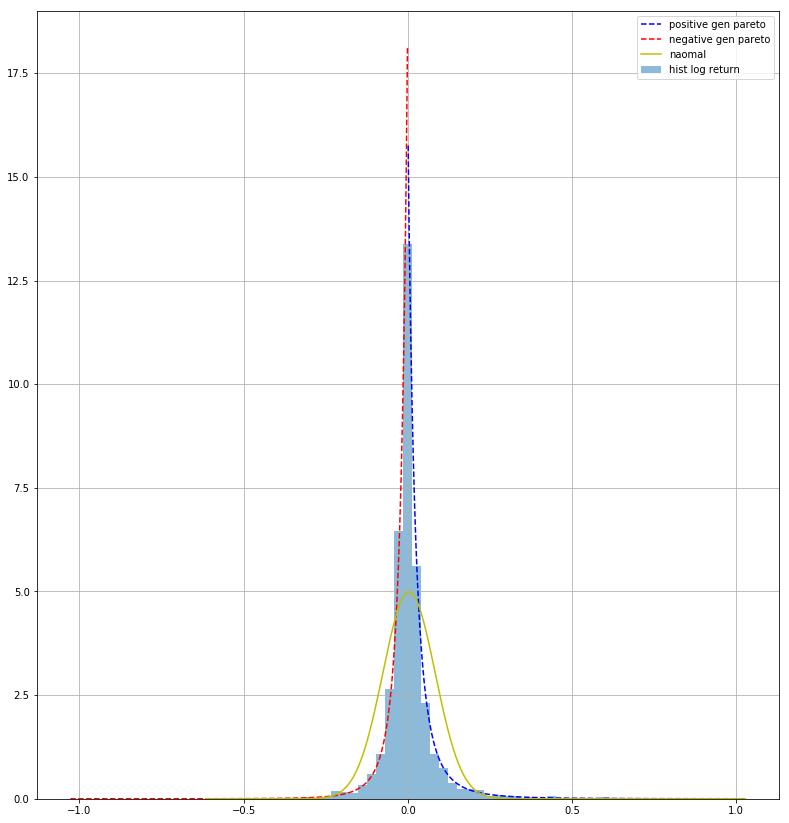

In [45]:
print('histgram of whole set plotted with halves fitted gen pareto')

numbins = int(60) 
logR.hist(bins = numbins, normed=True, alpha = 0.5)
x_ticks = np.linspace(min(logR), max(abs(logR)),1000)
plt.plot(domain, 0.5 *(stats.genpareto.pdf(domain, c =posi_gen_para[0] , loc = posi_gen_para[1], scale = posi_gen_para[2])), '--b')
plt.plot(-domain, 0.5 *(stats.genpareto.pdf(domain, c =nega_gen_para[0] , loc = nega_gen_para[1], scale = nega_gen_para[2])), '--r')
plt.plot(x_ticks, (stats.norm.pdf(x_ticks, mu_log, sigma_log)), 'y')

plt.legend(['positive gen pareto', 'negative gen pareto', 'naomal', 'hist log return'])

histgram of whole set plotted with whole set fitted t, mirror_fitted_t, and halves with gen pareto


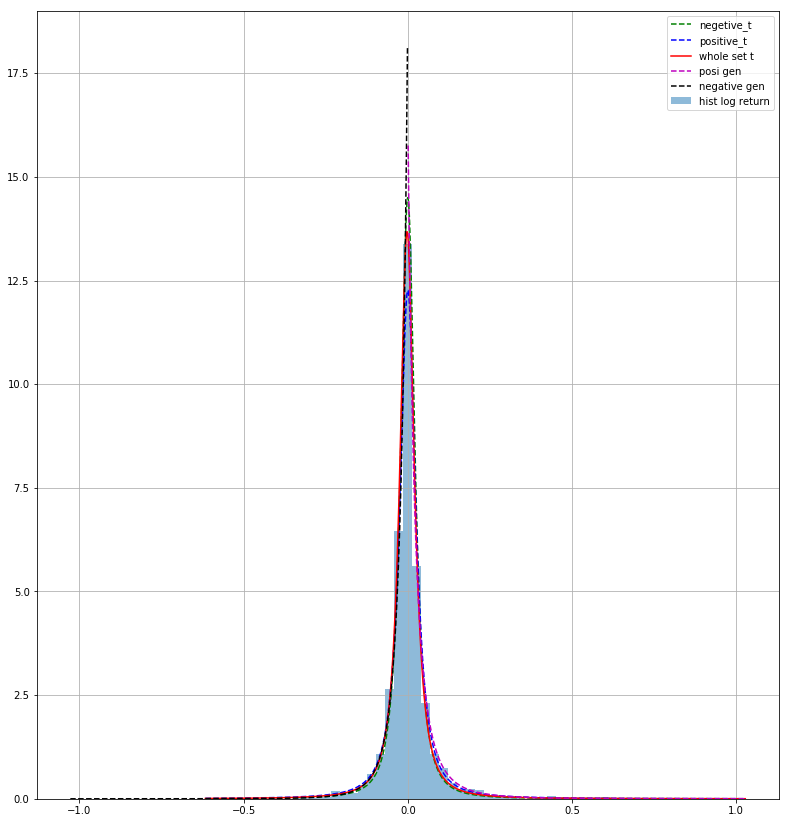

In [46]:
print('histgram of whole set plotted with whole set fitted t, mirror_fitted_t, and halves with gen pareto')

numbins = int(60) 
logR.hist(bins = numbins, normed=True, alpha = 0.5)
x_ticks = np.linspace(min(logR), max(abs(logR)),1000)
plt.plot(x_ticks, (stats.t.pdf(x_ticks, df = nega_t_para[0] , loc = nega_t_para[1], scale = nega_t_para[2])), '--g')
plt.plot(x_ticks, (stats.t.pdf(x_ticks, df = posi_t_para[0] , loc = posi_t_para[1], scale = posi_t_para[2])), '--b')
plt.plot(x_ticks, (stats.t.pdf(x_ticks, df = t_para[0] , loc = t_para[1], scale = t_para[2])), 'r', )
#plt.plot(logR_grid, pdf, '--r')
plt.plot(domain, 0.5 *(stats.genpareto.pdf(domain, c =posi_gen_para[0] , loc = posi_gen_para[1], scale = posi_gen_para[2])), '--m')
plt.plot(-domain, 0.5 *(stats.genpareto.pdf(domain, c =nega_gen_para[0] , loc = nega_gen_para[1], scale = nega_gen_para[2])), '--k')
plt.legend(['negetive_t', 'positive_t', 'whole set t', 'posi gen', 'negative gen', 'hist log return'])


In [47]:
#what is this magical * 2 thing? Should I do it for all the fitted distribution for the whole set of data while plot with 
#halves? why distribution fitted with halves match worse than fitted with whole? Data points? still 2000+
#lay out of report

In [48]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.0001, 0.02, 500)},
                    cv=10) 
grid.fit(logR[:, None])
kde = grid.best_estimator_
print (grid.best_params_)

{'bandwidth': 0.02}


In [49]:
logR_grid = np.linspace(min(logR) - 0.05, max(logR) + 0.05, 1000)
pdf = np.exp(kde.score_samples(logR_grid[:, None]))

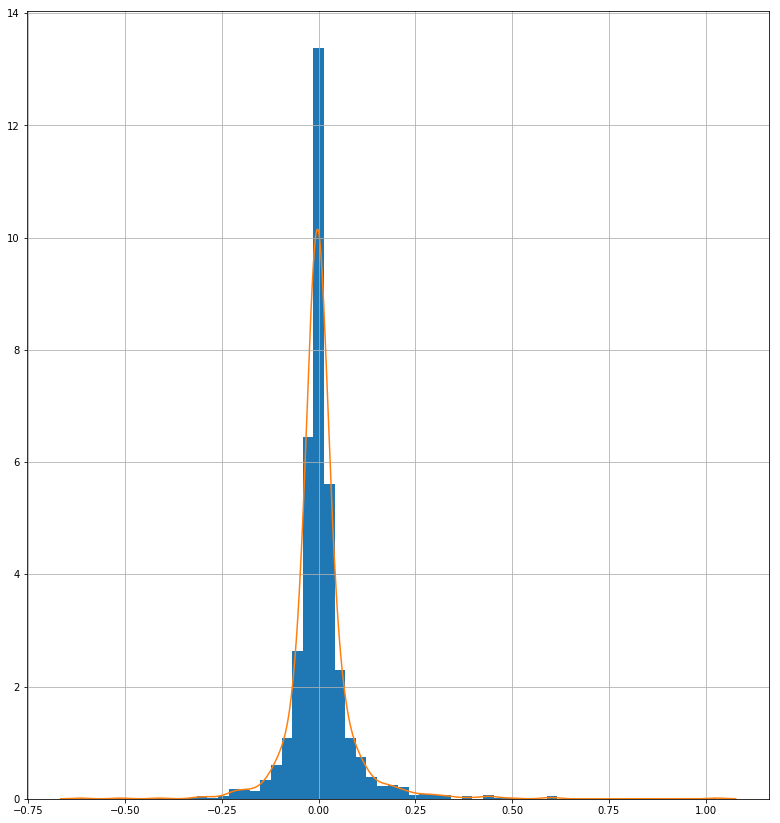

In [50]:
#%matplotlib tk
pdf_002 = pdf
numbins = int(60) 
logR.hist(bins = numbins, normed=True)
plt.plot(logR_grid, pdf_002)